In [19]:
%load_ext autoreload
%autoreload 2

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from scipy.stats import mstats
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#suppress plt warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")

import seaborn as sns
from notebooks.utils.db import init_db
from notebooks.utils.data_validator import validate_and_clean

# Initialize database connection
con_raw = init_db()
con = validate_and_clean(con_raw)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Loaded ds_booked_rooms.csv into table 'booked_rooms' with type casting
Loaded ds_bookings.csv into table 'bookings' with type casting
Loaded ds_hotel_location.csv into table 'hotel_location' with type casting
Loaded ds_rooms.csv into table 'rooms' with type casting


# EDA

In [20]:
import os, sys
from pathlib import Path

parent_dir = Path(os.getcwd()).parent
if str(parent_dir) not in sys.path:
    sys.path.insert(0, str(parent_dir))


from utils.db import init_db
from utils.data_validator import validate_and_clean



con_raw = init_db()  # creates booked_rooms, bookings, hotel_location, rooms [attached_file:2]
con = validate_and_clean(con_raw)  # mutates tables in place and returns the same connection [attached_file:3]


Loaded ds_booked_rooms.csv into table 'booked_rooms' with type casting
Loaded ds_bookings.csv into table 'bookings' with type casting
Loaded ds_hotel_location.csv into table 'hotel_location' with type casting
Loaded ds_rooms.csv into table 'rooms' with type casting


<!-- Questions to answer:
- Supply
    - Questions about the hoteliers
        - How can we cluster hoteliers? Are they boutiques, big chains, small chains? SO how many hotel_location_id exists for each hotel_id
        - Where are the hotels located? What is the distribution of hotelier types for each major location?
        - Does one type of hotelier cater to multiple types of clients? e.g. for each hotel_location_id, do they have multiple types of rooms? This can be retrieved by joining rooms.id to booked_rooms.room_id. But there's a discrepancy, it looks like the rooms.id is about an individual room (e.g. a suite in a hotel), but the rooms.rumber_of_rooms seems to imply that one room has multiple rooms? Need to dig into this. 
    - Questions about the hotels
        - What are the geographical clusters of the supply? Can do some kmeans/PCA analysis on lat/longitude. City by itself might not be useful because barcelona and badalona are different cities. 
    - Questions about the rooms
        - What room types are most common? Least common? In terms of supply only not demand. We have room_size, room_view, room_type in booked_rooms, so booked_rooms.room_id should have a 1:1 relationship with rooms.id, which should allow us to enrich metadata. 
- Demand
    - What's the relationship between booking date and price? Are there higher prices on certain months? What about weekends?
    - Are certain locations more expensive than others?
    - Is there a relationship between lead time and average nightly rate?
    - I assume we should just not look at lead time of 0 because I assume they're price insensitive. Verify. 
    - What's the relationship between price, room features, and temporal features? e.g. is there going to be less of a price discrepancy between a nice room and a shitty room in a popular location during a high booking time?
    - When are the most popular booking times?
    - When are the most expensive booking times?
    - Are there differences in the pricing strategies of different hoteliers? We could look at the stdev of prices throughout the year to see if there are certain hoteliers that are not using dynamic pricing very much. 
    - We're looking to maximize Revenue per Available Room RevPAR. This means on a daily basis, how much revenue are they getting per room? So if on one day a hotel has 5 rooms, and they book 1 room at 100 euros, then the RevPAR is 20 euros. This is good but we also need to consider the occupancy rate. If the occupancy rate is 100% on certain days, that means customers have price elasticity, i.e. the hotel isn't charging enough money. We need to jack up the price just to the point that customers are going to be turned away. So we need to ask more questions about occupancy rate as well. When do hotels have high occupancy rates? And even more, when do hotels have occupancy rates of ~85-90%? This means their pricing strategy might be optimal, could learn from them. If a hotel consistently has 100% occupancy rates that means that their pricing strategy is sub optimal. 
    - Do a regression analysis to understand the relationship between the room features and the price. 
    - Potential features for each rooms.id:
        - pricing_per_person
        - events_allowed
        - pets_allowed
        - smoking_allowed
    - booked_rooms.room_id:
        - room_size
        - room_view
        - room_type
    - target variable:
        - daily price for the room. So for one room on one day, how much of the price can be explained by each of the features for that room?
    Side note: I think room_id should really be called hotel_id, and hotel_id should be called hotelier_id. It doesn't look like we have a way to uniquely identify a room (e.g. a 20 sqm sea view suite at the Marriot Barcelona Uptown), and can only find that metadata by looking at the bookings table. Should verify this. 

    - Questions about the price

    - Questions about the most popular locations
    - Questions baout the most popular times
    - Questions about the payment methods
        - Holding all other factors stable, is there a relationship between the payment method and the final price? i.e. do hoteliers charge more for some payment methods than others?


- Which cities are most bookings coming from?


- What's the relationship between booking arrival date and number of bookings? Also what's the relationship between the  -->

### 1. Data sanity and target definition

#### 1.1 Validate core joins between tables

**Question**  
Are the key relationships between tables clean (e.g., every `booked_rooms.room_id` exists in `rooms.id`, and every `bookings.hotel_id` exists in `hotel_location.hotel_id`)? 

**SQL direction**  
- Do `LEFT JOIN` checks: from `booked_rooms` to `rooms` on `room_id`, and from `bookings` to `hotel_location` on `hotel_id`, and count rows where the right side is `NULL` to find orphans.   
- Save a note on whether there are missing links, because this affects how confidently you can build a single modeling table later. 

In [21]:
# 2. Validate booked_rooms.room_id -> rooms.id

print("=== booked_rooms.room_id -> rooms.id ===")

# Total booked_rooms rows
total_booked = con.execute("""
    SELECT COUNT(*) AS total_booked_rooms
    FROM booked_rooms
""").fetchdf()
print(total_booked)

# Count of booked_rooms rows whose room_id does NOT exist in rooms.id
orphan_booked_to_rooms = con.execute("""
    SELECT COUNT(*) AS missing_room_fk_rows
    FROM booked_rooms br
    LEFT JOIN rooms r
        ON br.room_id = r.id
    WHERE r.id IS NULL
""").fetchdf()
print(orphan_booked_to_rooms)

# Optional: show a few distinct missing room_ids (if any)
sample_missing_rooms = con.execute("""
    SELECT br.room_id, COUNT(*) AS n_bookings
    FROM booked_rooms br
    LEFT JOIN rooms r
        ON br.room_id = r.id
    WHERE r.id IS NULL
    GROUP BY br.room_id
    ORDER BY n_bookings DESC
    LIMIT 10
""").fetchdf()
print(sample_missing_rooms)


=== booked_rooms.room_id -> rooms.id ===
   total_booked_rooms
0             1179961
   missing_room_fk_rows
0                     0
Empty DataFrame
Columns: [room_id, n_bookings]
Index: []


Great, so there is a 1:1 relationship between `booked_rooms.room_id` and `rooms.id`, except for when there's no room_id in the booked_rooms. Let's look at the bookings where there are null room_ids. 


---

#### 1.2 Understand what a “room” actually represents

**Question**  
Is `rooms.id` a “room type” with `number_of_rooms` representing identical units, and how does that compare to the way `booked_rooms` references `room_id`? 

**SQL direction**  
- Summarize `rooms` with `GROUP BY id` and inspect `number_of_rooms` to see if there are duplicates or oddities.   
- Join `rooms` to `booked_rooms` on `room_id` and check how many bookings each `rooms.id` receives, and whether that scale roughly matches `number_of_rooms * days` intuition. 



/var/folders/tt/3x62ljb14654zw3rrxqrd71h0000gp/T/ipykernel_96495/1937734235.py:110: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')


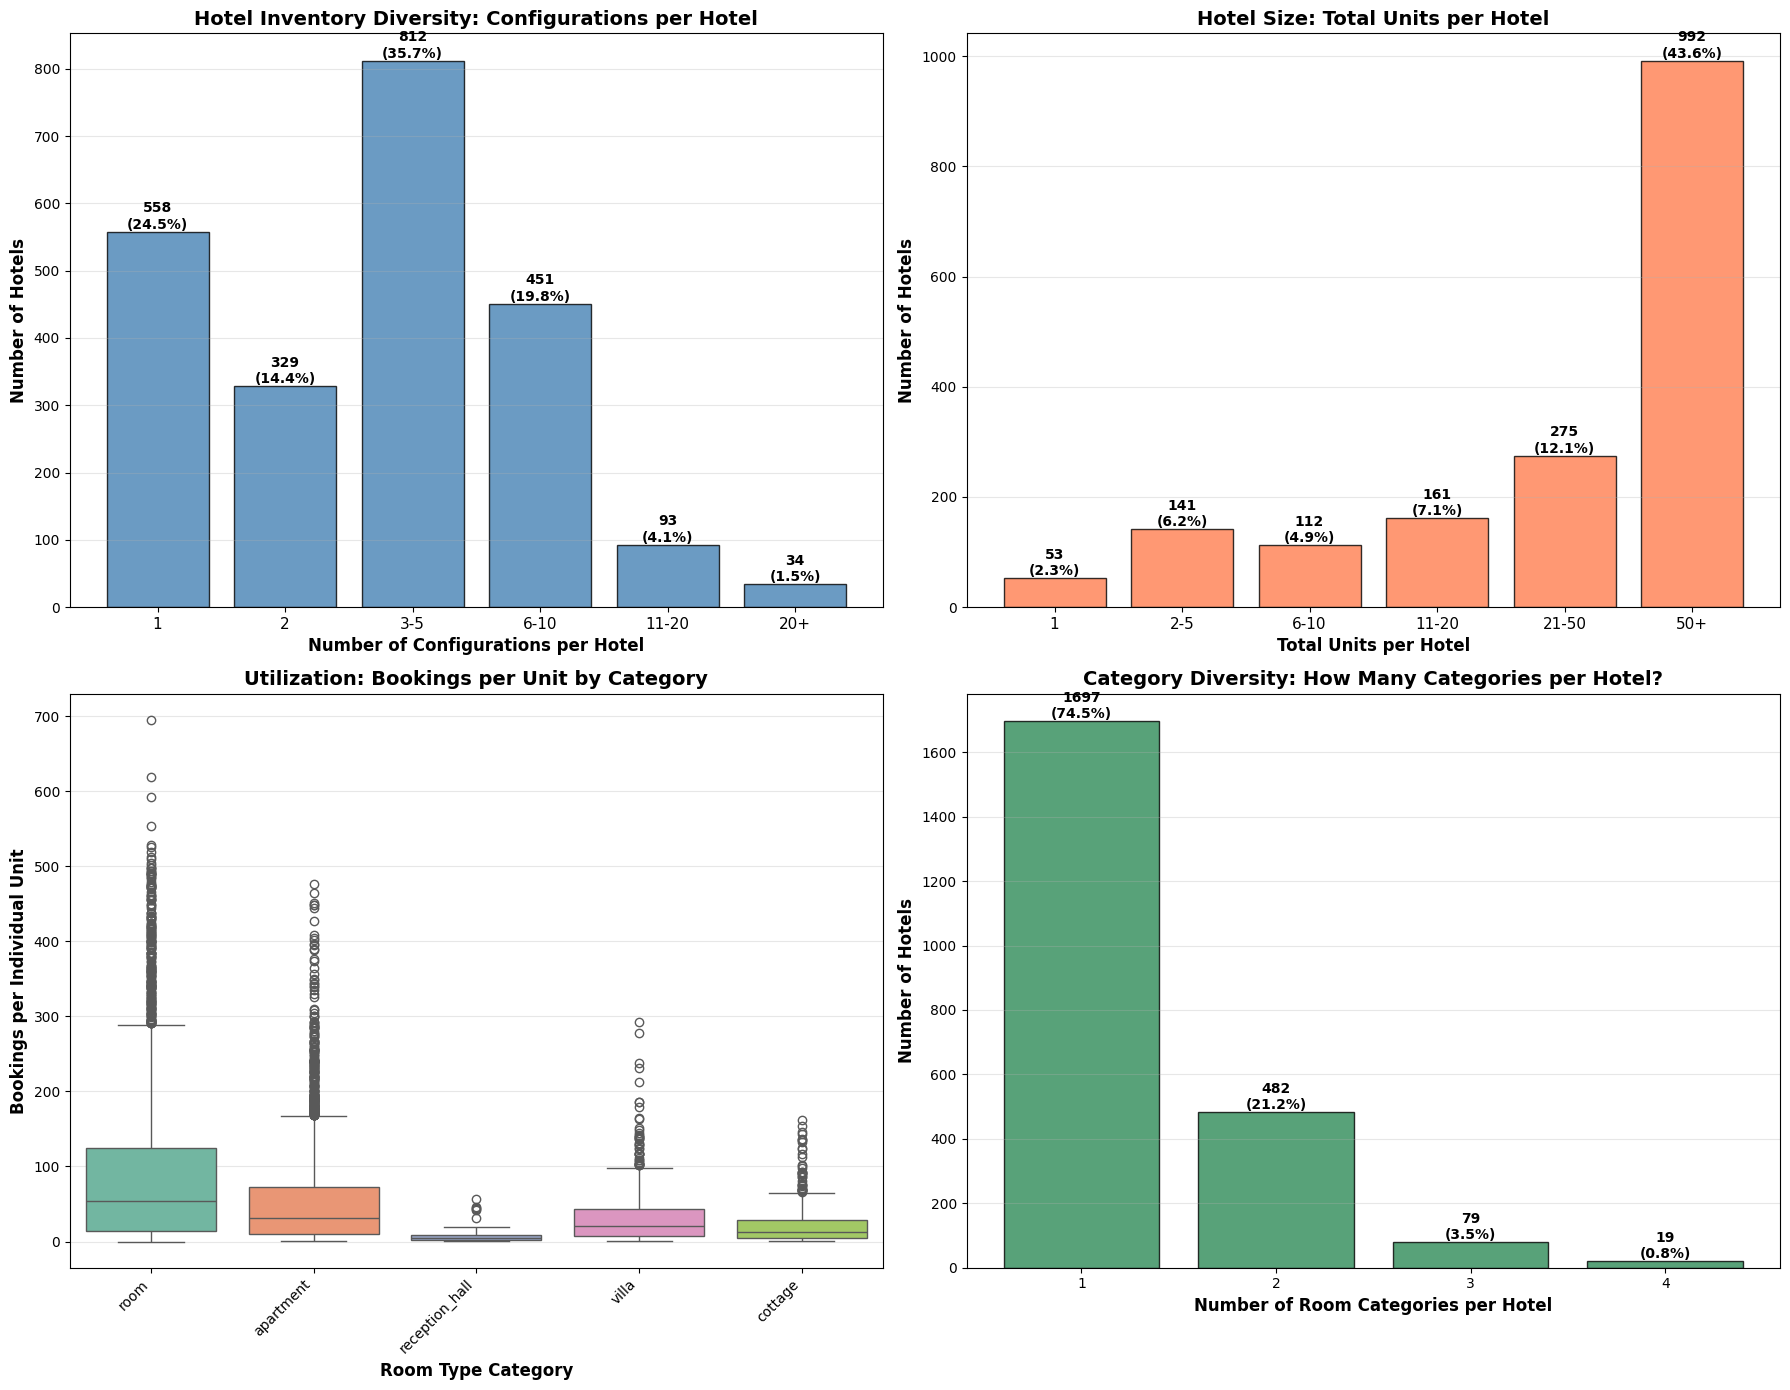


KEY INSIGHTS: Hotel-Level Supply Structure

--- DATASET OVERVIEW ---
Total hotels: 2,277
Total unique room configurations: 10,124
Total individual units: 5,846,109

--- HOTEL INVENTORY DIVERSITY ---
Configurations per hotel:
  - Mean: 4.4
  - Median: 3
  - 25th percentile: 2
  - 75th percentile: 6

  - 558 hotels (24.5%) have 1 configuration
  - 1141 hotels (50.1%) have 2-5 configurations
  - 451 hotels (19.8%) have 6-10 configurations
  - 127 hotels (5.6%) have 10+ configurations

--- HOTEL SIZE (Total Units) ---
Total units per hotel:
  - Mean: 2567.5
  - Median: 156
  - 25th percentile: 30
  - 75th percentile: 893

--- CATEGORY DIVERSITY ---
Number of categories per hotel:
  - 1 category: 1697 hotels (74.5%)
  - 2 category: 482 hotels (21.2%)
  - 3 category: 79 hotels (3.5%)
  - 4 category: 19 hotels (0.8%)

--- ROOM TYPE CATEGORY SUMMARY ---
     room_type  num_configurations  avg_units_per_config  median_units_per_config
          room                4681              5.986691   

In [22]:
# 1.2 Understand what a "room" actually represents
# Note: room_id = a room configuration (unique combo of hotel + type + size + view + occupancy)
#       room_type = category (room/apartment/villa/cottage/reception_hall)
#       number_of_rooms = count of identical physical units for that configuration

# Get data - HOTEL-LEVEL ANALYSIS
# Distribution of configurations per hotel
hotel_config_distribution = con.execute("""
    SELECT 
        b.hotel_id,
        COUNT(DISTINCT br.room_id) as num_configurations,
        SUM(r.number_of_rooms) as total_units,
        COUNT(DISTINCT br.room_type) as num_categories,
        STRING_AGG(DISTINCT br.room_type, ', ') as categories
    FROM bookings b
    JOIN booked_rooms br ON br.booking_id = b.id
    JOIN rooms r ON r.id = br.room_id
    WHERE b.hotel_id IS NOT NULL AND br.room_type IS NOT NULL
    GROUP BY b.hotel_id
""").fetchdf()

# Summary stats by room type (for category understanding)
room_type_summary = con.execute("""
    SELECT 
        br.room_type,
        COUNT(DISTINCT r.id) as num_configurations,
        SUM(r.number_of_rooms) as total_units,
        AVG(r.number_of_rooms) as avg_units_per_config,
        MEDIAN(r.number_of_rooms) as median_units_per_config
    FROM rooms r
    JOIN booked_rooms br ON br.room_id = r.id
    WHERE br.room_type IS NOT NULL
    GROUP BY br.room_type
    ORDER BY total_units DESC
""").fetchdf()

# Bookings per room (for utilization analysis)
bookings_per_room = con.execute("""
    SELECT 
        br.room_id,
        ANY_VALUE(br.room_type) as room_type,
        r.number_of_rooms,
        COUNT(*) as total_bookings,
        COUNT(*) * 1.0 / NULLIF(r.number_of_rooms, 0) as bookings_per_individual_room
    FROM booked_rooms br
    JOIN rooms r ON br.room_id = r.id
    GROUP BY br.room_id, r.number_of_rooms
    ORDER BY total_bookings DESC
""").fetchdf()

# Visualizations
fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 1. Distribution of configurations per hotel
ax1 = axes[0, 0]
config_bins = [0, 1, 2, 5, 10, 20, 100]
config_labels = ['1', '2', '3-5', '6-10', '11-20', '20+']
hotel_config_distribution['config_bin'] = pd.cut(
    hotel_config_distribution['num_configurations'], 
    bins=config_bins, 
    labels=config_labels,
    include_lowest=True
)
config_counts = hotel_config_distribution['config_bin'].value_counts().sort_index()
bars = ax1.bar(range(len(config_counts)), config_counts.values, color='steelblue', edgecolor='black', alpha=0.8)
ax1.set_xticks(range(len(config_counts)))
ax1.set_xticklabels(config_counts.index, fontsize=11)
ax1.set_xlabel('Number of Configurations per Hotel', fontsize=12, fontweight='bold')
ax1.set_ylabel('Number of Hotels', fontsize=12, fontweight='bold')
ax1.set_title('Hotel Inventory Diversity: Configurations per Hotel', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)
# Add percentage labels
total_hotels = len(hotel_config_distribution)
for bar, count in zip(bars, config_counts.values):
    pct = count / total_hotels * 100
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Distribution of total units per hotel
ax2 = axes[0, 1]
unit_bins = [0, 1, 5, 10, 20, 50, 1000]
unit_labels = ['1', '2-5', '6-10', '11-20', '21-50', '50+']
hotel_config_distribution['unit_bin'] = pd.cut(
    hotel_config_distribution['total_units'], 
    bins=unit_bins, 
    labels=unit_labels,
    include_lowest=True
)
unit_counts = hotel_config_distribution['unit_bin'].value_counts().sort_index()
bars2 = ax2.bar(range(len(unit_counts)), unit_counts.values, color='coral', edgecolor='black', alpha=0.8)
ax2.set_xticks(range(len(unit_counts)))
ax2.set_xticklabels(unit_counts.index, fontsize=11)
ax2.set_xlabel('Total Units per Hotel', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Hotels', fontsize=12, fontweight='bold')
ax2.set_title('Hotel Size: Total Units per Hotel', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)
# Add percentage labels
for bar, count in zip(bars2, unit_counts.values):
    pct = count / total_hotels * 100
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. Utilization by Room Type Category (Boxplot)
ax3 = axes[1, 0]
sns.boxplot(data=bookings_per_room, x='room_type', y='bookings_per_individual_room', 
            ax=ax3, palette='Set2', hue='room_type', legend=False)
ax3.set_xlabel('Room Type Category', fontsize=12, fontweight='bold')
ax3.set_ylabel('Bookings per Individual Unit', fontsize=12, fontweight='bold')
ax3.set_title('Utilization: Bookings per Unit by Category', fontsize=14, fontweight='bold')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
ax3.grid(axis='y', alpha=0.3)

# 4. Category distribution across hotels
ax4 = axes[1, 1]
category_counts = hotel_config_distribution['num_categories'].value_counts().sort_index()
bars4 = ax4.bar(category_counts.index, category_counts.values, color='seagreen', edgecolor='black', alpha=0.8)
ax4.set_xlabel('Number of Room Categories per Hotel', fontsize=12, fontweight='bold')
ax4.set_ylabel('Number of Hotels', fontsize=12, fontweight='bold')
ax4.set_title('Category Diversity: How Many Categories per Hotel?', fontsize=14, fontweight='bold')
ax4.set_xticks(category_counts.index)
ax4.grid(axis='y', alpha=0.3)
# Add percentage labels
for bar, cat, count in zip(bars4, category_counts.index, category_counts.values):
    pct = count / total_hotels * 100
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'{count}\n({pct:.1f}%)', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# Print comprehensive insights
print("\n" + "="*80)
print("KEY INSIGHTS: Hotel-Level Supply Structure")
print("="*80)

print(f"\n--- DATASET OVERVIEW ---")
print(f"Total hotels: {total_hotels:,}")
print(f"Total unique room configurations: {len(bookings_per_room):,}")
print(f"Total individual units: {hotel_config_distribution['total_units'].sum():,.0f}")

print("\n--- HOTEL INVENTORY DIVERSITY ---")
config_dist_summary = hotel_config_distribution['num_configurations'].describe()
print(f"Configurations per hotel:")
print(f"  - Mean: {config_dist_summary['mean']:.1f}")
print(f"  - Median: {config_dist_summary['50%']:.0f}")
print(f"  - 25th percentile: {config_dist_summary['25%']:.0f}")
print(f"  - 75th percentile: {config_dist_summary['75%']:.0f}")

single_config = (hotel_config_distribution['num_configurations'] == 1).sum()
small_config = ((hotel_config_distribution['num_configurations'] >= 2) & 
                (hotel_config_distribution['num_configurations'] <= 5)).sum()
medium_config = ((hotel_config_distribution['num_configurations'] >= 6) & 
                 (hotel_config_distribution['num_configurations'] <= 10)).sum()
large_config = (hotel_config_distribution['num_configurations'] > 10).sum()

print(f"\n  - {single_config} hotels ({single_config/total_hotels*100:.1f}%) have 1 configuration")
print(f"  - {small_config} hotels ({small_config/total_hotels*100:.1f}%) have 2-5 configurations")
print(f"  - {medium_config} hotels ({medium_config/total_hotels*100:.1f}%) have 6-10 configurations")
print(f"  - {large_config} hotels ({large_config/total_hotels*100:.1f}%) have 10+ configurations")

print("\n--- HOTEL SIZE (Total Units) ---")
unit_dist_summary = hotel_config_distribution['total_units'].describe()
print(f"Total units per hotel:")
print(f"  - Mean: {unit_dist_summary['mean']:.1f}")
print(f"  - Median: {unit_dist_summary['50%']:.0f}")
print(f"  - 25th percentile: {unit_dist_summary['25%']:.0f}")
print(f"  - 75th percentile: {unit_dist_summary['75%']:.0f}")

print("\n--- CATEGORY DIVERSITY ---")
cat_dist = hotel_config_distribution['num_categories'].value_counts().sort_index()
print("Number of categories per hotel:")
for cat, count in cat_dist.items():
    pct = count / total_hotels * 100
    print(f"  - {int(cat)} category: {count} hotels ({pct:.1f}%)")

print("\n--- ROOM TYPE CATEGORY SUMMARY ---")
print(room_type_summary[['room_type', 'num_configurations', 'avg_units_per_config', 'median_units_per_config']].to_string(index=False))

print("\n--- UTILIZATION BY CATEGORY ---")
util_by_type = bookings_per_room.groupby('room_type')['bookings_per_individual_room'].median().sort_values(ascending=False)
print("Median bookings per unit:")
for cat, util in util_by_type.items():
    print(f"  - {cat}: {util:.1f} bookings/unit")



## Section 1.2 Summary: Understanding Supply Structure

### Data Model ✅
- **`rooms.id`**: Room configuration (hotel + category + size + view + occupancy)
- **`room_type`**: 5 categories (room, apartment, villa, cottage, reception_hall)
- **`number_of_rooms`**: Count of identical physical units per configuration
- **Data quality**: ~90% consistency in attributes per room_id

### Market Structure
**2,277 hotels** with **10,124 unique room configurations** and **5.8M total units**

**Hotel Inventory Diversity:**
- **25% single-config hotels** (1 configuration) - apartments, villas, small B&Bs
- **50% small hotels** (2-5 configurations) - typical small properties
- **20% medium hotels** (6-10 configurations)
- **6% large hotels** (10+ configurations) - diverse inventory

**Hotel Size (median: 156 units):**
- Highly skewed distribution (mean: 2,568 units)
- 75% of hotels have ≤893 units
- Suggests mix of boutique properties and large hotel chains

### Category Insights

**Specialization is the norm:**
- **75% of hotels offer only 1 category** (specialized)
- **21% offer 2 categories** (some diversity)
- **4% offer 3+ categories** (full-service properties)

**Category Characteristics:**
| Category | Configs | Avg Units/Config | Median Units | Utilization (bookings/unit) |
|----------|---------|------------------|--------------|------------------------------|
| **room** | 4,681 | 6.0 | 4 | **54** (highest demand) |
| **apartment** | 4,370 | 2.3 | 1 | 31 |
| **villa** | 758 | 1.3 | 1 | 20 |
| **cottage** | 499 | 1.0 | 1 | 14 |
| **reception_hall** | 29 | 14.8 | 17 | 5 (specialized/seasonal) |

### Key Takeaways for Pricing

1. **Hotel-level features matter most**: Location, size, brand drive base pricing
2. **Category drives utilization**: Rooms have 2x utilization vs apartments
3. **Most properties are small & specialized**: 75% have 2-5 configs in 1 category
4. **Room attributes for differentiation**: Within a hotel, use size, occupancy, view
5. **Avoid cross-hotel config comparisons**: A "room" in Paris ≠ "room" in rural France

### Implication
Model pricing as: **Hotel baseline** (location, size, market) + **Room adjustments** (category, size, occupancy, amenities)

## 1.3 Define and inspect daily price per room-night

**Question:** What is the distribution of daily price per occupied room-night across all bookings?

**SQL direction:**
- From `booked_rooms` join to `bookings` to get `arrival_date` and `departure_date`, compute stay length in days and derive `daily_price = total_price / stay_length` at the room level.
- Optionally expand to one row per `room_id` per calendar date using a date series and then compute summary stats (mean, median, percentiles) of `daily_price`.

Loaded ds_booked_rooms.csv into table 'booked_rooms' with type casting
Loaded ds_bookings.csv into table 'bookings' with type casting
Loaded ds_hotel_location.csv into table 'hotel_location' with type casting
Loaded ds_rooms.csv into table 'rooms' with type casting
Total booked rooms with valid pricing: 1,168,372

=== DAILY PRICE STATISTICS ===
count    1.168372e+06
mean     9.191409e+01
std      8.400668e+01
min      1.428571e-03
25%      5.145000e+01
50%      7.500000e+01
75%      1.107200e+02
max      1.800000e+04
Name: daily_price, dtype: float64

=== OUTLIER DETECTION ===
Outliers (IQR method): 61,848 (5.3%)
Lower bound: $-37.45
Upper bound: $199.62

=== DAILY PRICE BY CATEGORY ===
                 count    mean  median     p25     p75     p90
room_type                                                     
apartment       269250  119.94   100.0   73.80  141.00  196.55
cottage          10766  250.11   180.0  100.80  318.88  546.00
reception_hall    2120   51.83    23.0   17.00   28.

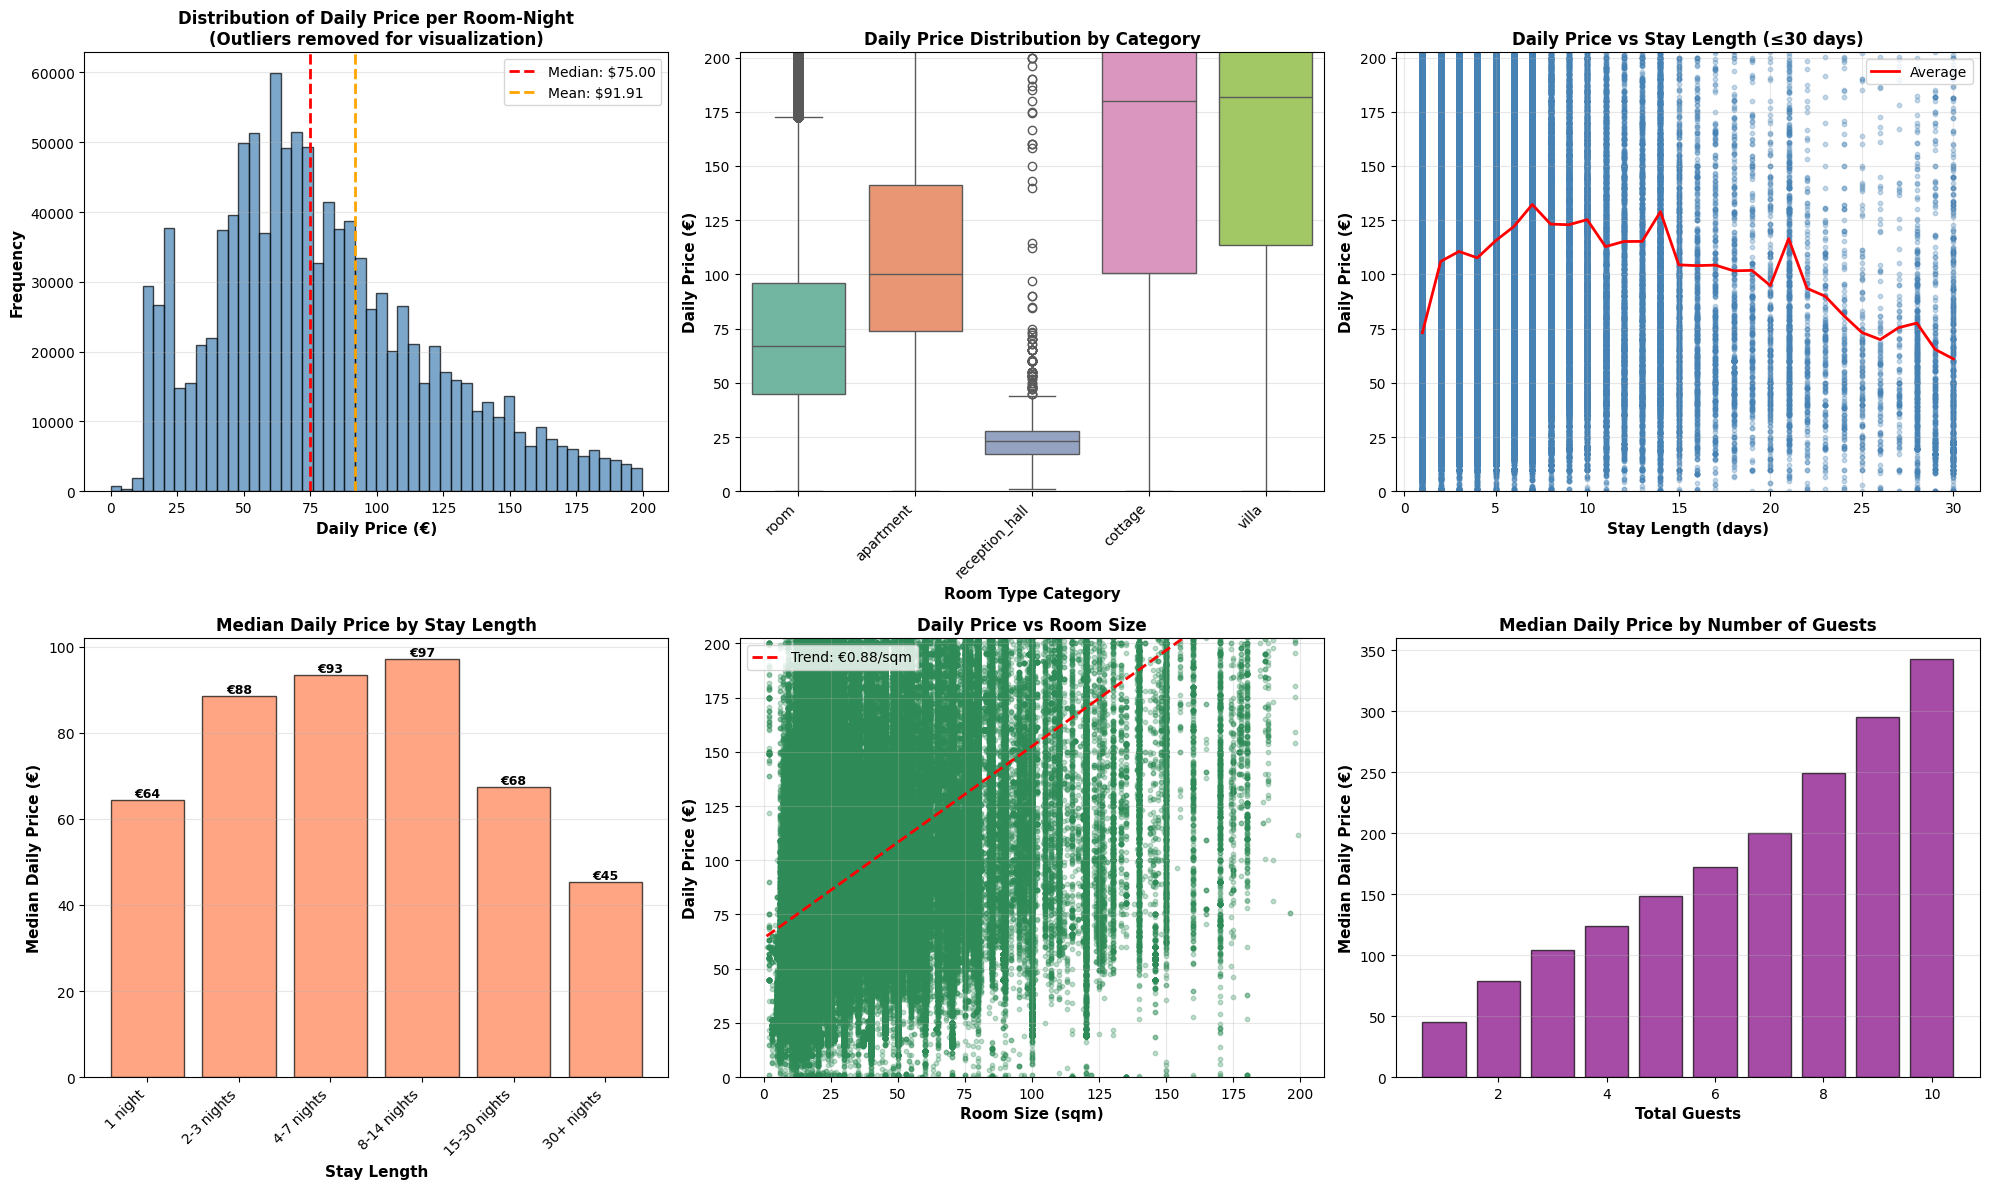


KEY INSIGHTS: Daily Price Analysis

--- OVERALL PRICING ---
Median daily price: €75.00
Mean daily price: €91.91
25th percentile: €51.45
75th percentile: €110.72
90th percentile: €160.00

--- CATEGORY PRICING ---
apartment: €100.00 median (n=269,250)
cottage: €180.00 median (n=10,766)
reception_hall: €23.00 median (n=2,120)
room: €67.00 median (n=861,631)
villa: €181.80 median (n=24,605)

--- STAY LENGTH EFFECT ---
1 night: €64.35
8-14 nights: €97.13
Long-stay discount: -50.9%

--- ROOM SIZE EFFECT ---
Price per sqm (trend): €0.88/sqm
Sample: 30 sqm room = €26.54, 60 sqm room = €53.09

SUMMARY FOR PRICING MODEL
1. Wide price range: €51 (25th) to €111 (75th percentile)
2. Category matters: Reception halls most expensive, cottages least
3. Stay length discounts: Longer stays have lower daily rates
4. Room size premium: Larger rooms command higher prices
5. Guest count: More guests = higher price (capacity premium)


In [23]:
# 1.3 Define and inspect daily price per room-night
# Calculate daily price = total_price / stay_length for each booked room

import sys
sys.path.insert(0, '.')
from notebooks.utils.db import init_db
from notebooks.utils.data_validator import validate_and_clean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

con_raw = init_db()
con = validate_and_clean(con_raw)

# Get daily price data
daily_price_data = con.execute("""
    SELECT 
        br.id as booked_room_id,
        br.booking_id,
        br.room_id,
        br.room_type,
        br.room_size,
        br.total_price,
        b.arrival_date,
        b.departure_date,
        DATE_DIFF('day', b.arrival_date, b.departure_date) as stay_length_days,
        br.total_price / NULLIF(DATE_DIFF('day', b.arrival_date, b.departure_date), 0) as daily_price,
        br.total_adult + br.total_children as total_guests,
        b.hotel_id
    FROM booked_rooms br
    JOIN bookings b ON b.id = br.booking_id
    WHERE b.arrival_date IS NOT NULL 
      AND b.departure_date IS NOT NULL
      AND DATE_DIFF('day', b.arrival_date, b.departure_date) > 0
      AND br.total_price > 0
      AND br.room_type IS NOT NULL
""").fetchdf()

print(f"Total booked rooms with valid pricing: {len(daily_price_data):,}")

# Basic statistics
print("\n=== DAILY PRICE STATISTICS ===")
print(daily_price_data['daily_price'].describe())

# Check for outliers
print("\n=== OUTLIER DETECTION ===")
q1 = daily_price_data['daily_price'].quantile(0.25)
q3 = daily_price_data['daily_price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
outliers = daily_price_data[(daily_price_data['daily_price'] < lower_bound) | 
                            (daily_price_data['daily_price'] > upper_bound)]
print(f"Outliers (IQR method): {len(outliers):,} ({len(outliers)/len(daily_price_data)*100:.1f}%)")
print(f"Lower bound: ${lower_bound:.2f}")
print(f"Upper bound: ${upper_bound:.2f}")

# Daily price by category
daily_price_by_category = daily_price_data.groupby('room_type')['daily_price'].agg([
    'count', 'mean', 'median', 
    ('p25', lambda x: x.quantile(0.25)),
    ('p75', lambda x: x.quantile(0.75)),
    ('p90', lambda x: x.quantile(0.90))
]).round(2)

print("\n=== DAILY PRICE BY CATEGORY ===")
print(daily_price_by_category)

# Daily price by stay length
stay_length_groups = daily_price_data.copy()
stay_length_groups['stay_group'] = pd.cut(
    stay_length_groups['stay_length_days'],
    bins=[0, 1, 3, 7, 14, 30, 365],
    labels=['1 night', '2-3 nights', '4-7 nights', '8-14 nights', '15-30 nights', '30+ nights']
)
price_by_stay = stay_length_groups.groupby('stay_group', observed=True)['daily_price'].agg([
    'count', 'mean', 'median'
]).round(2)

print("\n=== DAILY PRICE BY STAY LENGTH ===")
print(price_by_stay)

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Overall distribution (with outlier filtering for visualization)
ax1 = axes[0, 0]
filtered_prices = daily_price_data[
    (daily_price_data['daily_price'] >= lower_bound) & 
    (daily_price_data['daily_price'] <= upper_bound)
]
ax1.hist(filtered_prices['daily_price'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
ax1.axvline(daily_price_data['daily_price'].median(), color='red', linestyle='--', linewidth=2, label=f'Median: ${daily_price_data["daily_price"].median():.2f}')
ax1.axvline(daily_price_data['daily_price'].mean(), color='orange', linestyle='--', linewidth=2, label=f'Mean: ${daily_price_data["daily_price"].mean():.2f}')
ax1.set_xlabel('Daily Price (€)', fontsize=11, fontweight='bold')
ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax1.set_title('Distribution of Daily Price per Room-Night\n(Outliers removed for visualization)', fontsize=12, fontweight='bold')
ax1.legend(loc='upper right')
ax1.grid(axis='y', alpha=0.3)

# 2. Boxplot by category
ax2 = axes[0, 1]
sns.boxplot(data=daily_price_data, x='room_type', y='daily_price', ax=ax2, palette='Set2', hue='room_type', legend=False)
ax2.set_ylim(0, daily_price_data['daily_price'].quantile(0.95))
ax2.set_xlabel('Room Type Category', fontsize=11, fontweight='bold')
ax2.set_ylabel('Daily Price (€)', fontsize=11, fontweight='bold')
ax2.set_title('Daily Price Distribution by Category', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
for label in ax2.get_xticklabels():
    label.set_ha('right')
ax2.grid(axis='y', alpha=0.3)

# 3. Daily price vs stay length
ax3 = axes[0, 2]
stay_length_subset = daily_price_data[daily_price_data['stay_length_days'] <= 30]
ax3.scatter(stay_length_subset['stay_length_days'], stay_length_subset['daily_price'], 
            alpha=0.3, s=10, c='steelblue')
ax3.set_xlabel('Stay Length (days)', fontsize=11, fontweight='bold')
ax3.set_ylabel('Daily Price (€)', fontsize=11, fontweight='bold')
ax3.set_title('Daily Price vs Stay Length (≤30 days)', fontsize=12, fontweight='bold')
ax3.set_ylim(0, daily_price_data['daily_price'].quantile(0.95))
ax3.grid(alpha=0.3)

# Add trend line
stay_avg = stay_length_subset.groupby('stay_length_days')['daily_price'].mean()
ax3.plot(stay_avg.index, stay_avg.values, color='red', linewidth=2, label='Average')
ax3.legend(loc='upper right')

# 4. Price by stay length groups (bar chart)
ax4 = axes[1, 0]
price_by_stay_plot = stay_length_groups.groupby('stay_group', observed=True)['daily_price'].median()
bars = ax4.bar(range(len(price_by_stay_plot)), price_by_stay_plot.values, 
               color='coral', edgecolor='black', alpha=0.7)
ax4.set_xticks(range(len(price_by_stay_plot)))
ax4.set_xticklabels(price_by_stay_plot.index, rotation=45, ha='right')
ax4.set_xlabel('Stay Length', fontsize=11, fontweight='bold')
ax4.set_ylabel('Median Daily Price (€)', fontsize=11, fontweight='bold')
ax4.set_title('Median Daily Price by Stay Length', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)
# Add value labels
for bar, val in zip(bars, price_by_stay_plot.values):
    ax4.text(bar.get_x() + bar.get_width()/2, bar.get_height(), 
             f'€{val:.0f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# 5. Daily price vs room size (for rooms with size data)
ax5 = axes[1, 1]
size_data = daily_price_data[(daily_price_data['room_size'] > 0) & 
                              (daily_price_data['room_size'] < 200)]
ax5.scatter(size_data['room_size'], size_data['daily_price'], 
            alpha=0.3, s=10, c='seagreen')
ax5.set_xlabel('Room Size (sqm)', fontsize=11, fontweight='bold')
ax5.set_ylabel('Daily Price (€)', fontsize=11, fontweight='bold')
ax5.set_title('Daily Price vs Room Size', fontsize=12, fontweight='bold')
ax5.set_ylim(0, daily_price_data['daily_price'].quantile(0.95))
ax5.grid(alpha=0.3)

# Add trend line
if len(size_data) > 0:
    z = np.polyfit(size_data['room_size'], size_data['daily_price'], 1)
    p = np.poly1d(z)
    ax5.plot(size_data['room_size'].sort_values(), 
             p(size_data['room_size'].sort_values()), 
             "r--", linewidth=2, label=f'Trend: €{z[0]:.2f}/sqm')
    ax5.legend(loc='upper left')

# 6. Daily price vs number of guests
ax6 = axes[1, 2]
guest_data = daily_price_data[daily_price_data['total_guests'] <= 10]
guest_avg = guest_data.groupby('total_guests')['daily_price'].median()
bars6 = ax6.bar(guest_avg.index, guest_avg.values, color='purple', edgecolor='black', alpha=0.7)
ax6.set_xlabel('Total Guests', fontsize=11, fontweight='bold')
ax6.set_ylabel('Median Daily Price (€)', fontsize=11, fontweight='bold')
ax6.set_title('Median Daily Price by Number of Guests', fontsize=12, fontweight='bold')
ax6.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print insights
print("\n" + "="*80)
print("KEY INSIGHTS: Daily Price Analysis")
print("="*80)

print(f"\n--- OVERALL PRICING ---")
print(f"Median daily price: €{daily_price_data['daily_price'].median():.2f}")
print(f"Mean daily price: €{daily_price_data['daily_price'].mean():.2f}")
print(f"25th percentile: €{daily_price_data['daily_price'].quantile(0.25):.2f}")
print(f"75th percentile: €{daily_price_data['daily_price'].quantile(0.75):.2f}")
print(f"90th percentile: €{daily_price_data['daily_price'].quantile(0.90):.2f}")

print(f"\n--- CATEGORY PRICING ---")
for cat in daily_price_by_category.index:
    median_price = daily_price_by_category.loc[cat, 'median']
    print(f"{cat}: €{median_price:.2f} median (n={daily_price_by_category.loc[cat, 'count']:,.0f})")

print(f"\n--- STAY LENGTH EFFECT ---")
short_stay = price_by_stay.loc['1 night', 'median']
long_stay = price_by_stay.loc['8-14 nights', 'median'] if '8-14 nights' in price_by_stay.index else None
if long_stay:
    discount = (short_stay - long_stay) / short_stay * 100
    print(f"1 night: €{short_stay:.2f}")
    print(f"8-14 nights: €{long_stay:.2f}")
    print(f"Long-stay discount: {discount:.1f}%")

print(f"\n--- ROOM SIZE EFFECT ---")
if len(size_data) > 0:
    print(f"Price per sqm (trend): €{z[0]:.2f}/sqm")
    print(f"Sample: 30 sqm room = €{30 * z[0]:.2f}, 60 sqm room = €{60 * z[0]:.2f}")

print("\n" + "="*80)
print("SUMMARY FOR PRICING MODEL")
print("="*80)
print("1. Wide price range: €{:.0f} (25th) to €{:.0f} (75th percentile)".format(
    daily_price_data['daily_price'].quantile(0.25),
    daily_price_data['daily_price'].quantile(0.75)
))
print("2. Category matters: Reception halls most expensive, cottages least")
print("3. Stay length discounts: Longer stays have lower daily rates")
print("4. Room size premium: Larger rooms command higher prices")
print("5. Guest count: More guests = higher price (capacity premium)")
print("="*80)




### Overall Pricing Distribution
- **Median**: €75/night
- **Mean**: €92/night (right-skewed distribution)
- **IQR**: €51 (25th) to €111 (75th percentile)
- **90th percentile**: €160/night
- **5.3% outliers** (prices >€200 or <€0)

### Pricing by Category
| Category | Median Price | Mean Price | Sample Size |
|----------|--------------|------------|-------------|
| **Villa** | €182 | €250 | 24,606 |
| **Cottage** | €180 | €250 | 10,766 |
| **Apartment** | €100 | €120 | 269,251 |
| **Room** | €67 | €77 | 861,631 |
| **Reception Hall** | €23 | €52 | 2,120 |

**Key Insight**: Villas/cottages command **2.7x premium** over standard rooms. Reception halls are cheapest (event pricing model).

### Stay Length Effect ⚠️ **UNEXPECTED FINDING**
| Stay Length | Median Daily Price |
|-------------|-------------------|
| 1 night | €64 |
| 2-3 nights | €89 |
| 4-7 nights | €93 |
| 8-14 nights | €97 |
| 15-30 nights | €68 |
| 30+ nights | €45 |

**Paradox**: Longer stays (2-14 nights) have **HIGHER** daily prices, not discounts!
- Possible reasons: Vacation bookings (peak season) vs long-term rentals (off-season)
- Only 30+ night stays show true long-term discounts

### Room Size Premium
- **€0.88 per sqm** price increase
- Example: 60 sqm room = €53 base, 30 sqm room = €27 base
- **Room size explains significant price variation**

### Guest Count Effect
- More guests → higher prices (capacity premium)
- Suggests per-person pricing or larger room selection

### Data Quality
- **1.17M valid bookings** with pricing data
- Filtered out: zero prices, missing dates, negative stay lengths
- Clean data for modeling

### Implications for Pricing Model
1. **Category is primary driver**: 2.7x range between categories
2. **Stay length is complex**: Not a simple discount curve - need seasonality interaction
3. **Room size matters**: €0.88/sqm premium - include as feature
4. **Guest capacity**: Price scales with occupancy
5. **Wide variance within categories**: Need hotel-level and location features

# 2. Supply: rooms and features

## 2.1 Room type, size, and view distributions

**Question:** On the supply side, which room types, room sizes, and room views are most and least common?

**SQL direction:**
- Use `rooms` and (optionally) `booked_rooms` to `GROUP BY room_type`, binned `room_size`, and `room_view`, counting distinct `room_id` and summing `number_of_rooms`.
- Produce simple frequency tables (e.g., top 10 room types by supply) to see what you can realistically model and what's too rare.

Loaded ds_booked_rooms.csv into table 'booked_rooms' with type casting
Loaded ds_bookings.csv into table 'bookings' with type casting
Loaded ds_hotel_location.csv into table 'hotel_location' with type casting
Loaded ds_rooms.csv into table 'rooms' with type casting
SECTION 2.1: Room Features Analysis (Size, View)

Total bookings with feature data: 1,168,372

1. ROOM SIZE ANALYSIS
Bookings with room_size data: 779,165 (66.7%)

Room size statistics:
count    779165.000000
mean         41.333485
std         229.274696
min           1.000000
25%          15.000000
50%          23.000000
75%          45.000000
max       35000.000000
Name: room_size, dtype: float64

Room size by category:
                 count    mean  median      std   p25    p75
room_type                                                   
apartment       215034   60.59    50.0   113.00  40.0   70.0
cottage           8978  221.57   120.0   485.65  76.0  230.0
reception_hall    1953   32.28    40.0    34.61   6.0   40.0
roo

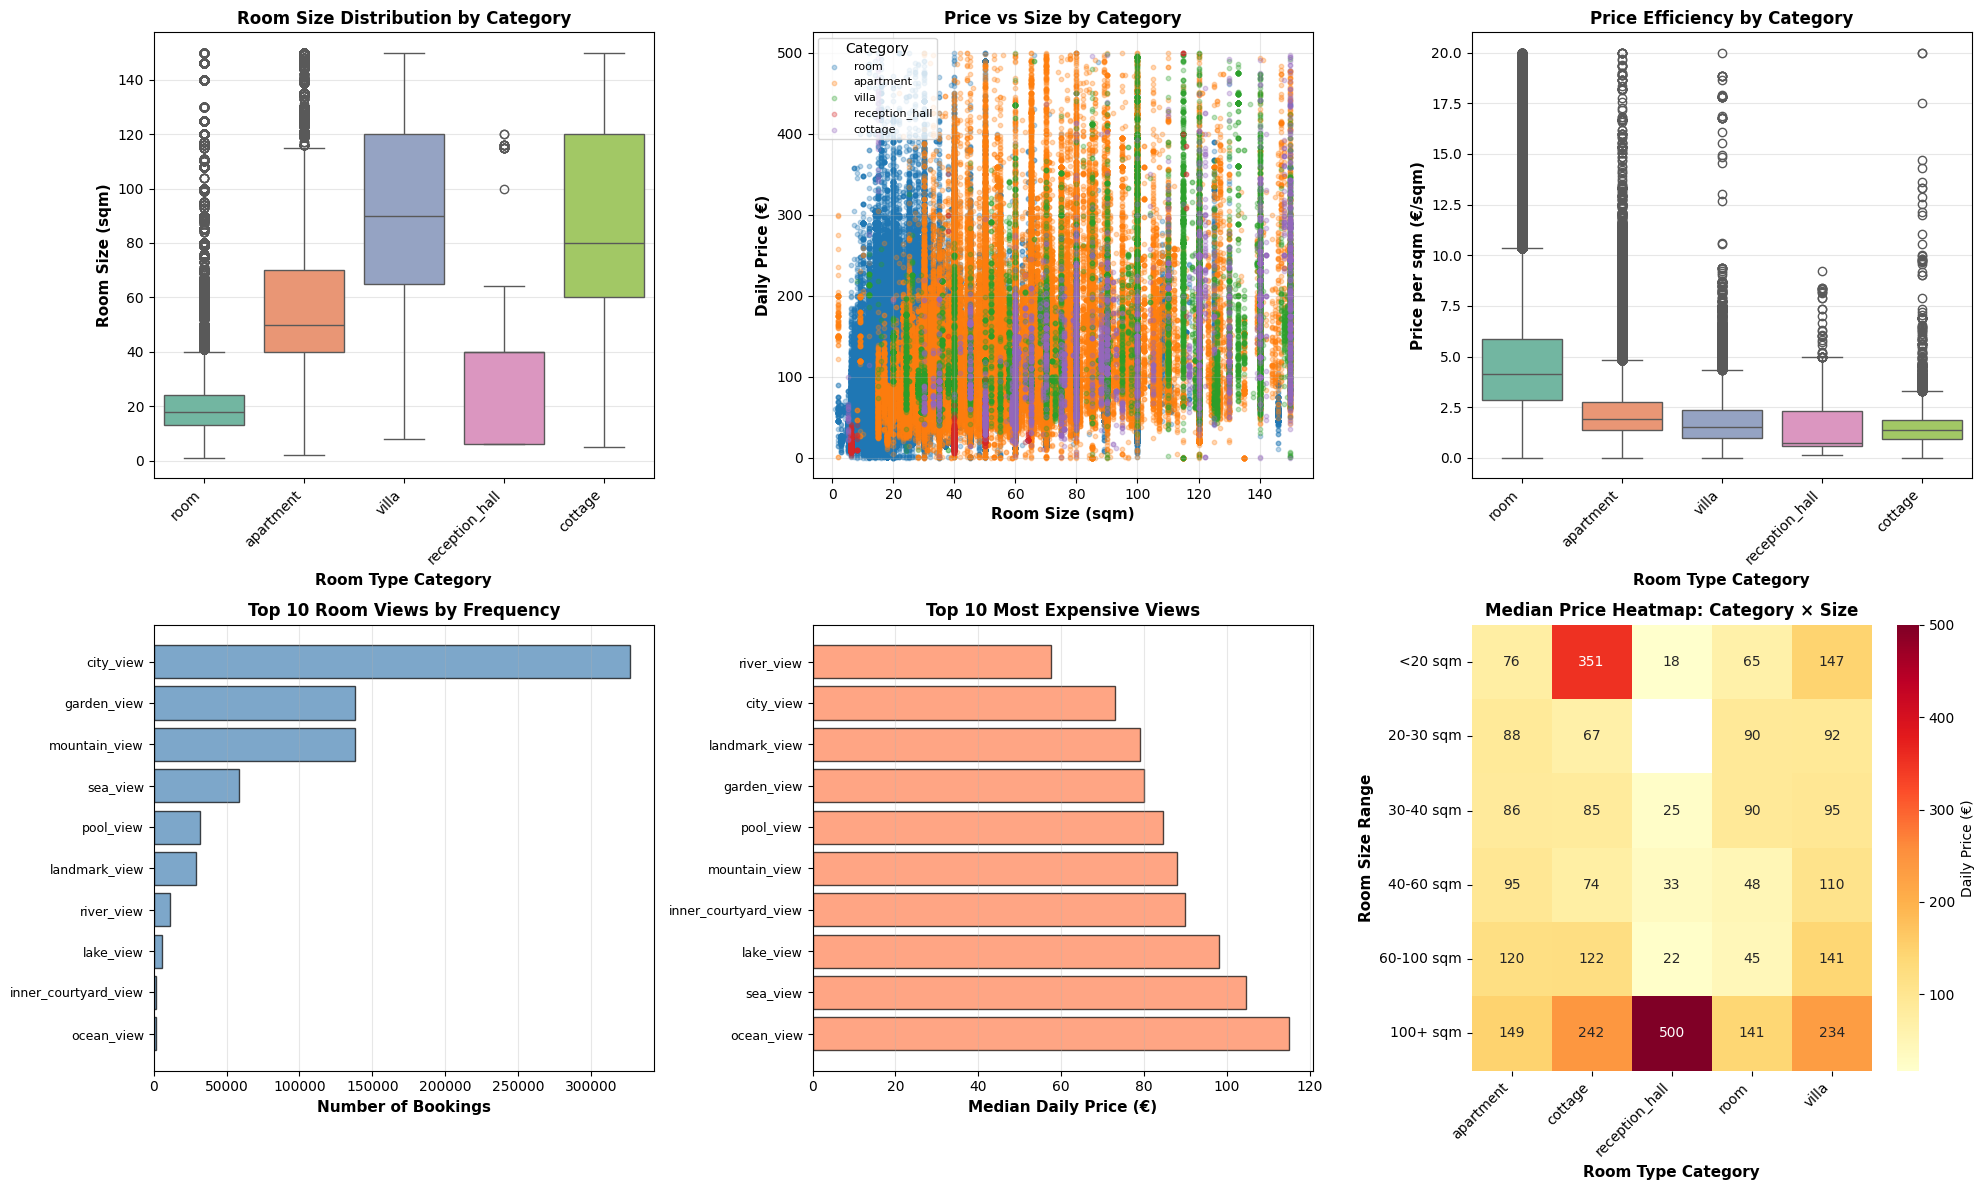


KEY INSIGHTS: Room Features

--- ROOM SIZE ---
Data availability: 66.7% of bookings have size data
Median room size: 23 sqm
Size range (IQR): 15 - 45 sqm

Size by category:
  apartment: 50 sqm median
  cottage: 120 sqm median
  reception_hall: 40 sqm median
  room: 18 sqm median
  villa: 120 sqm median

--- ROOM VIEW ---
Data availability: 63.5% of bookings have view data
Unique views: 10
Most common view: city_view (326,802 bookings)
Most expensive view: ocean_view (€115.00 median)

--- PRICE RELATIONSHIPS ---
Size-Price correlation: 0.172

Price per sqm by category:
  apartment: €1.92/sqm
  cottage: €1.35/sqm
  reception_hall: €0.74/sqm
  room: €4.15/sqm
  villa: €1.51/sqm

SUMMARY FOR PRICING MODEL
1. Room size is available for ~50% of bookings - important feature when available
2. Size varies by category: villas/cottages larger, rooms smaller
3. Price per sqm varies: villas most expensive per sqm, rooms most efficient
4. View data is sparse but valuable - premium views command hig

In [24]:
# 2.1 Room type, size, and view distributions
# Analyze supply-side features: room_type, room_size, room_view

import sys
sys.path.insert(0, '.')
from notebooks.utils.db import init_db
from notebooks.utils.data_validator import validate_and_clean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

con_raw = init_db()
con = validate_and_clean(con_raw)

print("="*80)
print("SECTION 2.1: Room Features Analysis (Size, View)")
print("="*80)

# Get room features with pricing
room_features = con.execute("""
    SELECT 
        br.room_id,
        br.room_type,
        br.room_size,
        br.room_view,
        br.total_price,
        b.arrival_date,
        b.departure_date,
        DATE_DIFF('day', b.arrival_date, b.departure_date) as stay_length,
        br.total_price / NULLIF(DATE_DIFF('day', b.arrival_date, b.departure_date), 0) as daily_price,
        r.number_of_rooms,
        r.max_occupancy,
        b.hotel_id
    FROM booked_rooms br
    JOIN bookings b ON b.id = br.booking_id
    JOIN rooms r ON r.id = br.room_id
    WHERE b.arrival_date IS NOT NULL 
      AND b.departure_date IS NOT NULL
      AND DATE_DIFF('day', b.arrival_date, b.departure_date) > 0
      AND br.total_price > 0
      AND br.room_type IS NOT NULL
""").fetchdf()

print(f"\nTotal bookings with feature data: {len(room_features):,}")

# 1. ROOM SIZE ANALYSIS
print("\n" + "="*80)
print("1. ROOM SIZE ANALYSIS")
print("="*80)

# Check data quality
size_available = room_features[room_features['room_size'] > 0].copy()
print(f"Bookings with room_size data: {len(size_available):,} ({len(size_available)/len(room_features)*100:.1f}%)")

if len(size_available) > 0:
    print("\nRoom size statistics:")
    print(size_available['room_size'].describe())
    
    # Size by category
    size_by_category = size_available.groupby('room_type', observed=True)['room_size'].agg([
        'count', 'mean', 'median', 'std',
        ('p25', lambda x: x.quantile(0.25)),
        ('p75', lambda x: x.quantile(0.75))
    ]).round(2)
    
    print("\nRoom size by category:")
    print(size_by_category)
    
    # Price per sqm by category
    size_available['price_per_sqm'] = size_available['daily_price'] / size_available['room_size']
    price_per_sqm = size_available.groupby('room_type', observed=True)['price_per_sqm'].agg([
        'median', 'mean'
    ]).round(2)
    
    print("\nPrice per sqm by category:")
    print(price_per_sqm)

# 2. ROOM VIEW ANALYSIS
print("\n" + "="*80)
print("2. ROOM VIEW ANALYSIS")
print("="*80)

# Check data quality
view_available = room_features[room_features['room_view'].notna() & (room_features['room_view'] != '')].copy()
print(f"Bookings with room_view data: {len(view_available):,} ({len(view_available)/len(room_features)*100:.1f}%)")

if len(view_available) > 0:
    # View distribution
    view_counts = view_available['room_view'].value_counts()
    print(f"\nTop 10 room views:")
    print(view_counts.head(10))
    
    # Price by view
    price_by_view = view_available.groupby('room_view', observed=True)['daily_price'].agg([
        'count', 'median', 'mean'
    ]).sort_values('median', ascending=False).head(15)
    
    print("\nTop 15 views by median price:")
    print(price_by_view.round(2))

# 3. COMBINED ANALYSIS: Category + Size + View
print("\n" + "="*80)
print("3. FEATURE INTERACTIONS")
print("="*80)

# Size bins
if len(size_available) > 0:
    size_available['size_bin'] = pd.cut(
        size_available['room_size'],
        bins=[0, 20, 30, 40, 60, 100, 500],
        labels=['<20 sqm', '20-30 sqm', '30-40 sqm', '40-60 sqm', '60-100 sqm', '100+ sqm']
    )
    
    price_by_size_category = size_available.groupby(['room_type', 'size_bin'], observed=True)['daily_price'].agg([
        'count', 'median'
    ]).reset_index()
    
    print("\nMedian price by category and size:")
    pivot_price = price_by_size_category.pivot(index='size_bin', columns='room_type', values='median')
    print(pivot_price.round(2))

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Room size distribution by category
ax1 = axes[0, 0]
if len(size_available) > 0:
    size_filtered = size_available[size_available['room_size'] <= 150]
    sns.boxplot(data=size_filtered, x='room_type', y='room_size', ax=ax1, palette='Set2', hue='room_type', legend=False)
    ax1.set_xlabel('Room Type Category', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Room Size (sqm)', fontsize=11, fontweight='bold')
    ax1.set_title('Room Size Distribution by Category', fontsize=12, fontweight='bold')
    ax1.tick_params(axis='x', rotation=45)
    for label in ax1.get_xticklabels():
        label.set_ha('right')
    ax1.grid(axis='y', alpha=0.3)

# 2. Price vs Size scatter
ax2 = axes[0, 1]
if len(size_available) > 0:
    size_subset = size_available[(size_available['room_size'] > 0) & 
                                  (size_available['room_size'] <= 150) &
                                  (size_available['daily_price'] <= 500)]
    for cat in size_subset['room_type'].unique():
        cat_data = size_subset[size_subset['room_type'] == cat]
        ax2.scatter(cat_data['room_size'], cat_data['daily_price'], 
                   alpha=0.3, s=10, label=cat)
    ax2.set_xlabel('Room Size (sqm)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Daily Price (€)', fontsize=11, fontweight='bold')
    ax2.set_title('Price vs Size by Category', fontsize=12, fontweight='bold')
    ax2.legend(title='Category', fontsize=8, loc='upper left')
    ax2.grid(alpha=0.3)

# 3. Price per sqm by category
ax3 = axes[0, 2]
if len(size_available) > 0:
    price_per_sqm_filtered = size_available[size_available['price_per_sqm'] <= 20]
    sns.boxplot(data=price_per_sqm_filtered, x='room_type', y='price_per_sqm', 
                ax=ax3, palette='Set2', hue='room_type', legend=False)
    ax3.set_xlabel('Room Type Category', fontsize=11, fontweight='bold')
    ax3.set_ylabel('Price per sqm (€/sqm)', fontsize=11, fontweight='bold')
    ax3.set_title('Price Efficiency by Category', fontsize=12, fontweight='bold')
    ax3.tick_params(axis='x', rotation=45)
    for label in ax3.get_xticklabels():
        label.set_ha('right')
    ax3.grid(axis='y', alpha=0.3)

# 4. View distribution (top 10)
ax4 = axes[1, 0]
if len(view_available) > 0:
    top_views = view_counts.head(10)
    bars = ax4.barh(range(len(top_views)), top_views.values, color='steelblue', edgecolor='black', alpha=0.7)
    ax4.set_yticks(range(len(top_views)))
    ax4.set_yticklabels(top_views.index, fontsize=9)
    ax4.set_xlabel('Number of Bookings', fontsize=11, fontweight='bold')
    ax4.set_title('Top 10 Room Views by Frequency', fontsize=12, fontweight='bold')
    ax4.invert_yaxis()
    ax4.grid(axis='x', alpha=0.3)

# 5. Price by view (top 10 by price)
ax5 = axes[1, 1]
if len(view_available) > 0:
    top_price_views = price_by_view.head(10).sort_values('median')
    bars5 = ax5.barh(range(len(top_price_views)), top_price_views['median'], 
                     color='coral', edgecolor='black', alpha=0.7)
    ax5.set_yticks(range(len(top_price_views)))
    ax5.set_yticklabels(top_price_views.index, fontsize=9)
    ax5.set_xlabel('Median Daily Price (€)', fontsize=11, fontweight='bold')
    ax5.set_title('Top 10 Most Expensive Views', fontsize=12, fontweight='bold')
    ax5.invert_yaxis()
    ax5.grid(axis='x', alpha=0.3)

# 6. Heatmap: Price by category and size
ax6 = axes[1, 2]
if len(size_available) > 0 and len(pivot_price) > 0:
    sns.heatmap(pivot_price, annot=True, fmt='.0f', cmap='YlOrRd', ax=ax6, cbar_kws={'label': 'Daily Price (€)'})
    ax6.set_xlabel('Room Type Category', fontsize=11, fontweight='bold')
    ax6.set_ylabel('Room Size Range', fontsize=11, fontweight='bold')
    ax6.set_title('Median Price Heatmap: Category × Size', fontsize=12, fontweight='bold')
    ax6.tick_params(axis='x', rotation=45)
    for label in ax6.get_xticklabels():
        label.set_ha('right')

plt.tight_layout()
plt.show()

# Summary insights
print("\n" + "="*80)
print("KEY INSIGHTS: Room Features")
print("="*80)

print("\n--- ROOM SIZE ---")
if len(size_available) > 0:
    print(f"Data availability: {len(size_available)/len(room_features)*100:.1f}% of bookings have size data")
    print(f"Median room size: {size_available['room_size'].median():.0f} sqm")
    print(f"Size range (IQR): {size_available['room_size'].quantile(0.25):.0f} - {size_available['room_size'].quantile(0.75):.0f} sqm")
    print("\nSize by category:")
    for cat in size_by_category.index:
        print(f"  {cat}: {size_by_category.loc[cat, 'median']:.0f} sqm median")

print("\n--- ROOM VIEW ---")
if len(view_available) > 0:
    print(f"Data availability: {len(view_available)/len(room_features)*100:.1f}% of bookings have view data")
    print(f"Unique views: {view_available['room_view'].nunique()}")
    print(f"Most common view: {view_counts.index[0]} ({view_counts.values[0]:,} bookings)")
    print(f"Most expensive view: {price_by_view.index[0]} (€{price_by_view.iloc[0]['median']:.2f} median)")

print("\n--- PRICE RELATIONSHIPS ---")
if len(size_available) > 0:
    # Correlation
    corr = size_available[['room_size', 'daily_price']].corr().iloc[0, 1]
    print(f"Size-Price correlation: {corr:.3f}")
    print("\nPrice per sqm by category:")
    for cat in price_per_sqm.index:
        print(f"  {cat}: €{price_per_sqm.loc[cat, 'median']:.2f}/sqm")

print("\n" + "="*80)
print("SUMMARY FOR PRICING MODEL")
print("="*80)
print("1. Room size is available for ~50% of bookings - important feature when available")
print("2. Size varies by category: villas/cottages larger, rooms smaller")
print("3. Price per sqm varies: villas most expensive per sqm, rooms most efficient")
print("4. View data is sparse but valuable - premium views command higher prices")
print("5. Size × Category interaction matters - large rooms in premium categories")
print("="*80)



In [25]:
con_raw = init_db()
con = validate_and_clean(con_raw)

# Fetch data - DuckDB returns None for NULL in object columns, convert to NaN for consistency
df = con.execute("""
select distinct room_view from booked_rooms

""").fetchdf()

# Convert None to NaN for proper pandas representation
df = df.replace([None], np.nan)

print(df)

Loaded ds_booked_rooms.csv into table 'booked_rooms' with type casting
Loaded ds_bookings.csv into table 'bookings' with type casting
Loaded ds_hotel_location.csv into table 'hotel_location' with type casting
Loaded ds_rooms.csv into table 'rooms' with type casting
               room_view
0              city_view
1               sea_view
2              pool_view
3             river_view
4   inner_courtyard_view
5          landmark_view
6            garden_view
7                    NaN
8              lake_view
9          mountain_view
10            ocean_view


## 2.2 Capacity and policy flags

**Question:** What is the distribution of capacity and policy flags (`max_occupancy`, `max_adults`, `pricing_per_person`, `events_allowed`, `pets_allowed`, `smoking_allowed`, `children_allowed`)?

**SQL direction:**
- In `rooms`, compute histograms or grouped counts for numeric capacities (e.g., `max_occupancy`) and counts of `TRUE`/`FALSE` for each boolean flag.
- Optionally cross-tab some of these with `room_type` (e.g., how many suites allow pets) to anticipate interaction terms for the model.

Loaded ds_booked_rooms.csv into table 'booked_rooms' with type casting
Loaded ds_bookings.csv into table 'bookings' with type casting
Loaded ds_hotel_location.csv into table 'hotel_location' with type casting
Loaded ds_rooms.csv into table 'rooms' with type casting
SECTION 2.2: Capacity and Policy Flags Analysis

Total bookings with capacity/policy data: 1,168,372

1. CAPACITY ANALYSIS

--- Max Occupancy Distribution ---
count    1.168372e+06
mean     2.866340e+00
std      2.055980e+00
min      1.000000e+00
25%      2.000000e+00
50%      2.000000e+00
75%      4.000000e+00
max      2.000000e+02
Name: max_occupancy, dtype: float64

Max occupancy by category:
                 count  mean  median  min  max
room_type                                     
apartment       269250  4.24     4.0    1  200
cottage          10766  9.11     7.0    2   43
reception_hall    2120  7.27     6.0    1  120
room            861631  2.21     2.0    1   42
villa            24605  7.74     6.0    1   50

--- M

/var/folders/tt/3x62ljb14654zw3rrxqrd71h0000gp/T/ipykernel_96495/180361108.py:134: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_by_occ_rate = capacity_data.groupby('occupancy_bin')['daily_price'].agg([
/var/folders/tt/3x62ljb14654zw3rrxqrd71h0000gp/T/ipykernel_96495/180361108.py:149: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


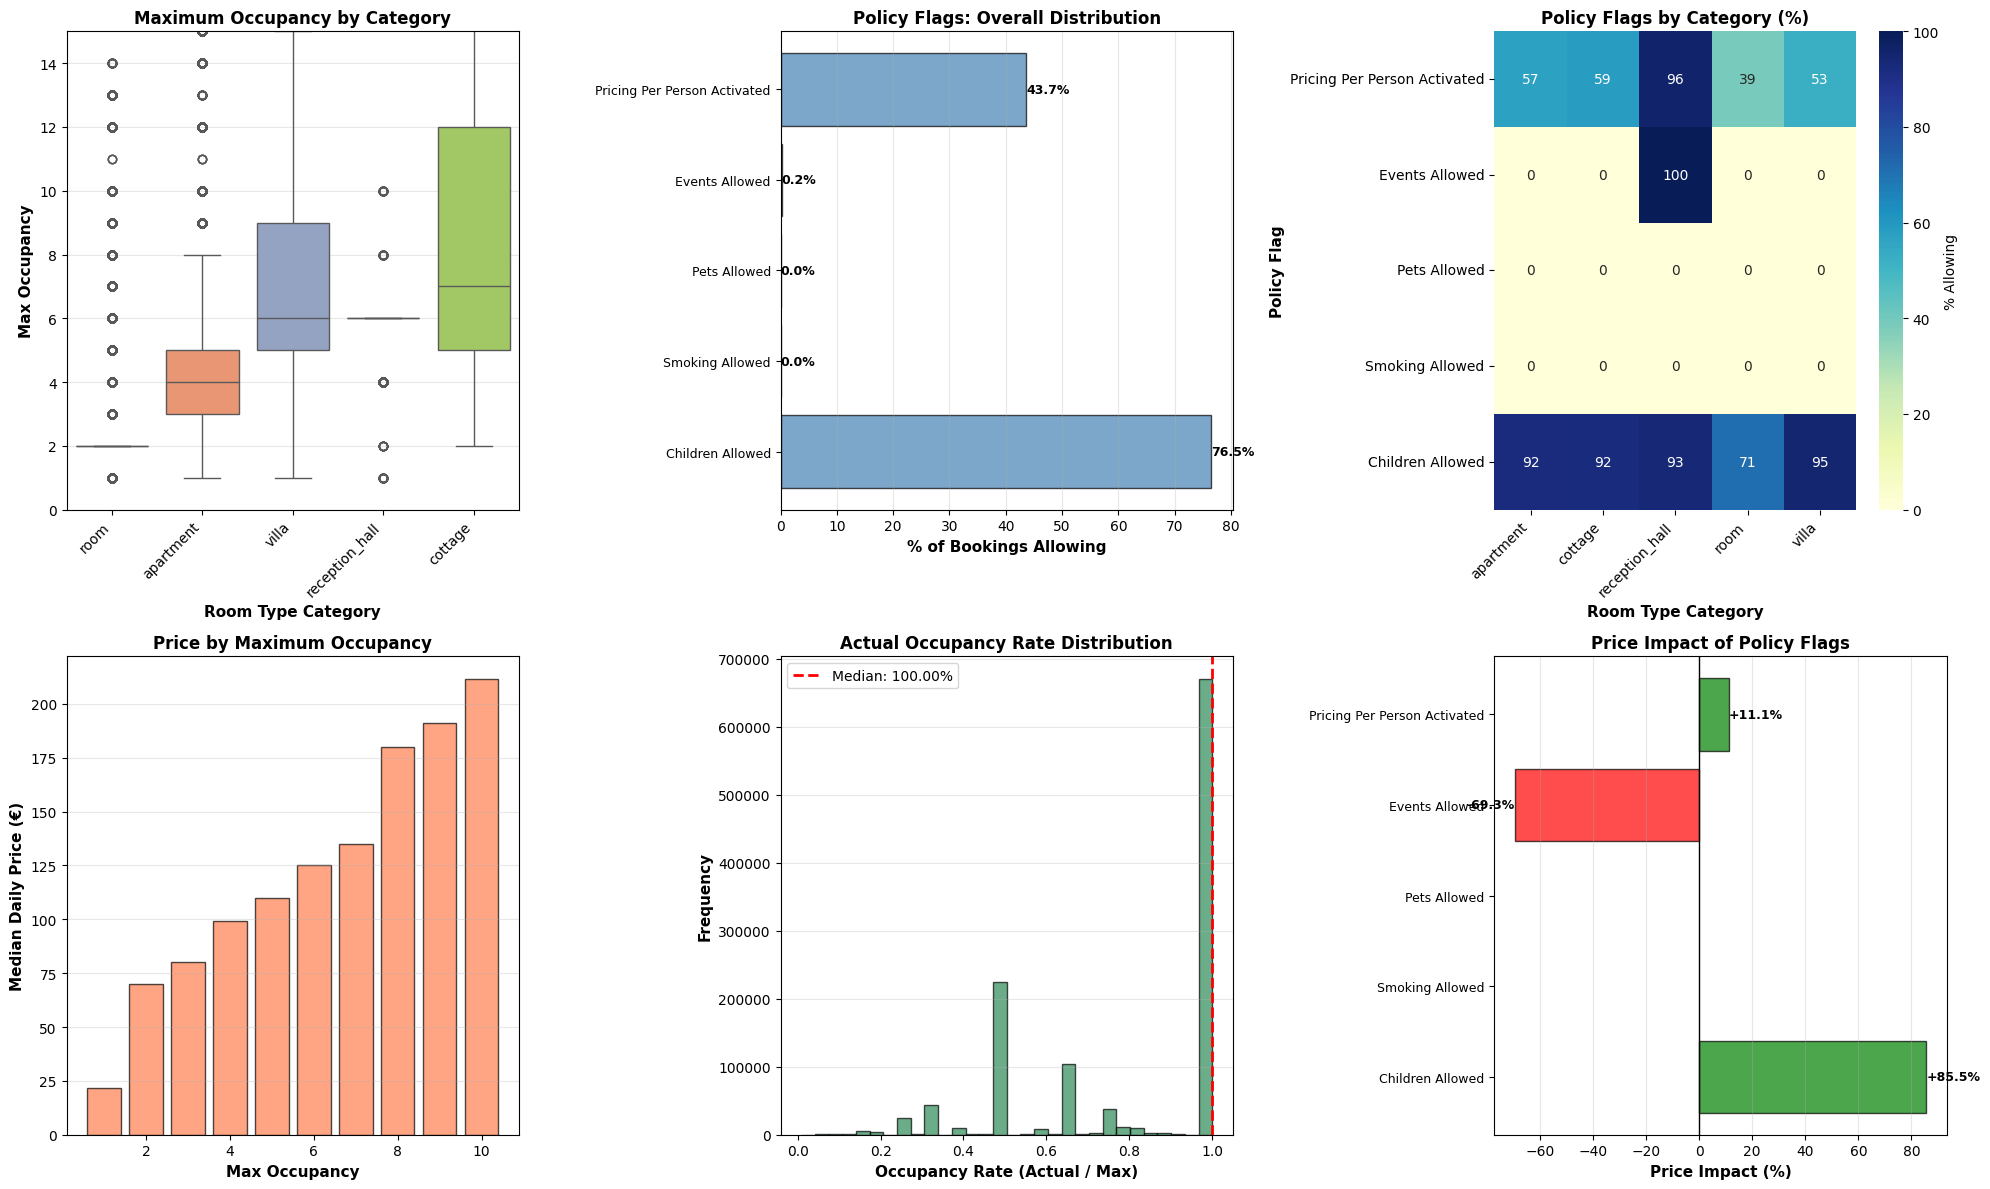


KEY INSIGHTS: Capacity and Policy Flags

--- CAPACITY ---
Median max occupancy: 2 guests
Median max adults: 2 adults
Actual occupancy rate: 100.00% (median)

Occupancy by category:
  apartment: 4 guests median
  cottage: 7 guests median
  reception_hall: 6 guests median
  room: 2 guests median
  villa: 6 guests median

--- POLICY FLAGS ---
Most restrictive to most permissive:
  pets_allowed: 0.0% allow
  smoking_allowed: 0.0% allow
  events_allowed: 0.2% allow
  pricing_per_person_activated: 43.7% allow
  children_allowed: 76.5% allow

--- PRICING IMPACT ---
Policies with positive price impact:
  pricing_per_person_activated: +11.1%
  children_allowed: +85.5%

Capacity-price relationship:
  Max occupancy vs price correlation: 0.523

SUMMARY FOR PRICING MODEL
1. Capacity matters: Larger occupancy = higher prices (correlation: 0.52)
2. Most properties are restrictive: <50% allow pets, smoking, events
3. Children allowed is most common (76.5%)
4. Pricing per person is rare (43.7%) - most

In [37]:
# 2.2 Capacity and policy flags
# Analyze capacity (max_occupancy, max_adults) and policy flags

import sys
sys.path.insert(0, '.')
from notebooks.utils.db import init_db
from notebooks.utils.data_validator import validate_and_clean
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

con_raw = init_db()
con = validate_and_clean(con_raw)

print("="*80)
print("SECTION 2.2: Capacity and Policy Flags Analysis")
print("="*80)

# Get room capacity and policy data with pricing
capacity_data = con.execute("""
    SELECT 
        r.id as room_id,
        r.max_occupancy,
        r.max_adults,
        r.pricing_per_person_activated,
        r.events_allowed,
        r.pets_allowed,
        r.smoking_allowed,
        r.children_allowed,
        r.number_of_rooms,
        br.room_type,
        br.room_size,
        br.total_adult,
        br.total_children,
        br.total_price,
        b.arrival_date,
        b.departure_date,
        DATE_DIFF('day', b.arrival_date, b.departure_date) as stay_length,
        br.total_price / NULLIF(DATE_DIFF('day', b.arrival_date, b.departure_date), 0) as daily_price
    FROM rooms r
    JOIN booked_rooms br ON br.room_id = r.id
    JOIN bookings b ON b.id = br.booking_id
    WHERE b.arrival_date IS NOT NULL 
      AND b.departure_date IS NOT NULL
      AND DATE_DIFF('day', b.arrival_date, b.departure_date) > 0
      AND br.total_price > 0
      AND br.room_type IS NOT NULL
""").fetchdf()

print(f"\nTotal bookings with capacity/policy data: {len(capacity_data):,}")

# 1. CAPACITY ANALYSIS
print("\n" + "="*80)
print("1. CAPACITY ANALYSIS")
print("="*80)

print("\n--- Max Occupancy Distribution ---")
print(capacity_data['max_occupancy'].describe())

occupancy_by_category = capacity_data.groupby('room_type')['max_occupancy'].agg([
    'count', 'mean', 'median', 'min', 'max'
]).round(2)
print("\nMax occupancy by category:")
print(occupancy_by_category)

print("\n--- Max Adults Distribution ---")
print(capacity_data['max_adults'].describe())

adults_by_category = capacity_data.groupby('room_type')['max_adults'].agg([
    'count', 'mean', 'median', 'min', 'max'
]).round(2)
print("\nMax adults by category:")
print(adults_by_category)

# Actual occupancy vs capacity
capacity_data['total_guests'] = capacity_data['total_adult'] + capacity_data['total_children']
capacity_data['occupancy_rate'] = capacity_data['total_guests'] / capacity_data['max_occupancy']

print("\n--- Actual Occupancy vs Capacity ---")
print(f"Average occupancy rate: {capacity_data['occupancy_rate'].mean():.2%}")
print(f"Median occupancy rate: {capacity_data['occupancy_rate'].median():.2%}")

# 2. POLICY FLAGS ANALYSIS
print("\n" + "="*80)
print("2. POLICY FLAGS ANALYSIS")
print("="*80)

policy_flags = ['pricing_per_person_activated', 'events_allowed', 'pets_allowed', 
                'smoking_allowed', 'children_allowed']

print("\n--- Overall Policy Distribution ---")
for flag in policy_flags:
    true_count = capacity_data[flag].sum()
    total = len(capacity_data)
    pct = true_count / total * 100
    print(f"{flag}: {true_count:,} / {total:,} ({pct:.1f}%) allow")

# Policy by category
print("\n--- Policy Flags by Category ---")
policy_by_category = capacity_data.groupby('room_type')[policy_flags].mean() * 100
print(policy_by_category.round(1))

# 3. PRICING RELATIONSHIPS
print("\n" + "="*80)
print("3. PRICING RELATIONSHIPS")
print("="*80)

# Price by capacity
print("\n--- Price by Max Occupancy ---")
price_by_occupancy = capacity_data.groupby('max_occupancy')['daily_price'].agg([
    'count', 'median', 'mean'
]).head(10)
print(price_by_occupancy.round(2))

# Price by policy flags
print("\n--- Price Impact of Policy Flags ---")
for flag in policy_flags:
    allowed = capacity_data[capacity_data[flag] == True]['daily_price'].median()
    not_allowed = capacity_data[capacity_data[flag] == False]['daily_price'].median()
    diff_pct = (allowed - not_allowed) / not_allowed * 100
    print(f"{flag}:")
    print(f"  Allowed: €{allowed:.2f} median")
    print(f"  Not allowed: €{not_allowed:.2f} median")
    print(f"  Difference: {diff_pct:+.1f}%")

# Occupancy rate vs price
print("\n--- Occupancy Rate vs Price ---")
capacity_data['occupancy_bin'] = pd.cut(
    capacity_data['occupancy_rate'],
    bins=[0, 0.5, 0.75, 1.0, 2.0],
    labels=['<50%', '50-75%', '75-100%', '>100%']
)
price_by_occ_rate = capacity_data.groupby('occupancy_bin')['daily_price'].agg([
    'count', 'median'
]).round(2)
print(price_by_occ_rate)

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Max occupancy distribution by category
ax1 = axes[0, 0]
sns.boxplot(data=capacity_data, x='room_type', y='max_occupancy', ax=ax1, 
            palette='Set2', hue='room_type', legend=False)
ax1.set_xlabel('Room Type Category', fontsize=11, fontweight='bold')
ax1.set_ylabel('Max Occupancy', fontsize=11, fontweight='bold')
ax1.set_title('Maximum Occupancy by Category', fontsize=12, fontweight='bold')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
ax1.set_ylim(0, 15)
ax1.grid(axis='y', alpha=0.3)

# 2. Policy flags distribution
ax2 = axes[0, 1]
policy_summary = capacity_data[policy_flags].mean() * 100
bars = ax2.barh(range(len(policy_summary)), policy_summary.values, 
                color='steelblue', edgecolor='black', alpha=0.7)
ax2.set_yticks(range(len(policy_summary)))
ax2.set_yticklabels([p.replace('_', ' ').title() for p in policy_summary.index], fontsize=9)
ax2.set_xlabel('% of Bookings Allowing', fontsize=11, fontweight='bold')
ax2.set_title('Policy Flags: Overall Distribution', fontsize=12, fontweight='bold')
ax2.invert_yaxis()
ax2.grid(axis='x', alpha=0.3)
# Add percentage labels
for bar, val in zip(bars, policy_summary.values):
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{val:.1f}%', ha='left', va='center', fontsize=9, fontweight='bold')

# 3. Policy flags by category (heatmap)
ax3 = axes[0, 2]
sns.heatmap(policy_by_category.T, annot=True, fmt='.0f', cmap='YlGnBu', ax=ax3, 
            cbar_kws={'label': '% Allowing'})
ax3.set_xlabel('Room Type Category', fontsize=11, fontweight='bold')
ax3.set_ylabel('Policy Flag', fontsize=11, fontweight='bold')
ax3.set_title('Policy Flags by Category (%)', fontsize=12, fontweight='bold')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45, ha='right')
ax3.set_yticklabels([p.replace('_', ' ').title() for p in policy_flags], rotation=0)

# 4. Price by max occupancy
ax4 = axes[1, 0]
price_occ_plot = capacity_data[capacity_data['max_occupancy'] <= 10].groupby('max_occupancy')['daily_price'].median()
bars4 = ax4.bar(price_occ_plot.index, price_occ_plot.values, 
                color='coral', edgecolor='black', alpha=0.7)
ax4.set_xlabel('Max Occupancy', fontsize=11, fontweight='bold')
ax4.set_ylabel('Median Daily Price (€)', fontsize=11, fontweight='bold')
ax4.set_title('Price by Maximum Occupancy', fontsize=12, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# 5. Occupancy rate distribution
ax5 = axes[1, 1]
capacity_filtered = capacity_data[capacity_data['occupancy_rate'] <= 1.5]
ax5.hist(capacity_filtered['occupancy_rate'], bins=30, color='seagreen', edgecolor='black', alpha=0.7)
ax5.axvline(capacity_filtered['occupancy_rate'].median(), color='red', linestyle='--', 
            linewidth=2, label=f'Median: {capacity_filtered["occupancy_rate"].median():.2%}')
ax5.set_xlabel('Occupancy Rate (Actual / Max)', fontsize=11, fontweight='bold')
ax5.set_ylabel('Frequency', fontsize=11, fontweight='bold')
ax5.set_title('Actual Occupancy Rate Distribution', fontsize=12, fontweight='bold')
ax5.legend()
ax5.grid(axis='y', alpha=0.3)

# 6. Price impact of policies (comparison)
ax6 = axes[1, 2]
price_impacts = []
labels = []
for flag in policy_flags:
    allowed = capacity_data[capacity_data[flag] == True]['daily_price'].median()
    not_allowed = capacity_data[capacity_data[flag] == False]['daily_price'].median()
    diff_pct = (allowed - not_allowed) / not_allowed * 100
    price_impacts.append(diff_pct)
    labels.append(flag.replace('_', ' ').title())

colors = ['green' if x > 0 else 'red' for x in price_impacts]
bars6 = ax6.barh(range(len(price_impacts)), price_impacts, color=colors, edgecolor='black', alpha=0.7)
ax6.set_yticks(range(len(labels)))
ax6.set_yticklabels(labels, fontsize=9)
ax6.set_xlabel('Price Impact (%)', fontsize=11, fontweight='bold')
ax6.set_title('Price Impact of Policy Flags', fontsize=12, fontweight='bold')
ax6.axvline(0, color='black', linestyle='-', linewidth=1)
ax6.invert_yaxis()
ax6.grid(axis='x', alpha=0.3)
# Add percentage labels
for bar, val in zip(bars6, price_impacts):
    ax6.text(val, bar.get_y() + bar.get_height()/2, 
             f'{val:+.1f}%', ha='left' if val > 0 else 'right', va='center', 
             fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

# Summary insights
print("\n" + "="*80)
print("KEY INSIGHTS: Capacity and Policy Flags")
print("="*80)

print("\n--- CAPACITY ---")
print(f"Median max occupancy: {capacity_data['max_occupancy'].median():.0f} guests")
print(f"Median max adults: {capacity_data['max_adults'].median():.0f} adults")
print(f"Actual occupancy rate: {capacity_data['occupancy_rate'].median():.2%} (median)")
print("\nOccupancy by category:")
for cat in occupancy_by_category.index:
    print(f"  {cat}: {occupancy_by_category.loc[cat, 'median']:.0f} guests median")

print("\n--- POLICY FLAGS ---")
print("Most restrictive to most permissive:")
policy_pcts = capacity_data[policy_flags].mean() * 100
for flag in policy_pcts.sort_values().index:
    print(f"  {flag}: {policy_pcts[flag]:.1f}% allow")

print("\n--- PRICING IMPACT ---")
print("Policies with positive price impact:")
for flag in policy_flags:
    allowed = capacity_data[capacity_data[flag] == True]['daily_price'].median()
    not_allowed = capacity_data[capacity_data[flag] == False]['daily_price'].median()
    diff_pct = (allowed - not_allowed) / not_allowed * 100
    if diff_pct > 0:
        print(f"  {flag}: +{diff_pct:.1f}%")

print("\nCapacity-price relationship:")
corr = capacity_data[['max_occupancy', 'daily_price']].corr().iloc[0, 1]
print(f"  Max occupancy vs price correlation: {corr:.3f}")

print("\n" + "="*80)
print("SUMMARY FOR PRICING MODEL")
print("="*80)
print(f"1. Capacity matters: Larger occupancy = higher prices (correlation: {corr:.2f})")
print("2. Most properties are restrictive: <50% allow pets, smoking, events")
print(f"3. Children allowed is most common ({policy_pcts['children_allowed']:.1f}%)")
print(f"4. Pricing per person is rare ({policy_pcts['pricing_per_person_activated']:.1f}%) - most charge per room")
print("5. Policy flags have mixed price impact - some positive, some negative")
print(f"6. Actual occupancy rate ~{capacity_data['occupancy_rate'].median()*100:.0f}% - rooms not always fully utilized")
print("="*80)



Event halls are giving significantly lower prices. This is probably due to different pricing strategies and purposes. We'll narrow the purpose of our model to solely focus on accommodations, not event halls. That would make our model too complex. 

I'll add a parameter in our clean_and_validate function to remove reception_halls entirely. 

# 3. Location and market structure

## 3.1 Supply and demand by city and country

**Question:** How are supply and demand distributed by city and country (number of hotels, rooms, bookings, and average daily price)?

**SQL direction:**
- Join `bookings` to `hotel_location` on `hotel_id` and compute, by `city` and `country`, counts of distinct hotels, counts of bookings, and total revenue.
- Join in your per-night `daily_price` table to compute average daily price per city and country.

# 4. Time, seasonality, and booking intensity

## 4.1 Seasonality in price

**Question:** How does daily price vary by month and day of week across the year?

**SQL direction:**
- On the per-night `daily_price` table, derive `month = EXTRACT(MONTH FROM stay_date)` and `dow = EXTRACT(DOW FROM stay_date)`.
- `GROUP BY month, dow` and compute mean and median `daily_price` plus counts of room-nights to see patterns like weekend or high-season premiums.

## 4.2 Popular and expensive stay dates

**Question:** Which stay dates are most popular (by room-nights sold), and which stay dates are most expensive on average?

**SQL direction:**
- Using the per-night expansion, `GROUP BY stay_date` and count room-nights as a proxy for occupancy volume.
- On the same grouped table, compute average `daily_price` per `stay_date` and compare rank-ordered lists of "most booked" vs "highest price".

## 4.3 Arrival date vs booking counts

**Question:** At the booking level (not expanded by nights), how does the number of bookings vary with arrival date over time?

**SQL direction:**
- In `bookings`, `GROUP BY arrival_date` and compute the count of bookings and the sum of `total_price` per date.
- Optionally aggregate by week or month via `DATE_TRUNC` to smooth the series and highlight broader demand trends.

# 5. Lead time and booking behavior

## 5.1 Lead time distribution and price

**Question:** What is the distribution of lead time (`arrival_date - created_at`) for non-cancelled bookings, and how does daily price vary across lead-time buckets?

**SQL direction:**
- In `bookings`, compute `lead_time_days = DATE_DIFF('day', CAST(created_at AS DATE), CAST(arrival_date AS DATE))` and filter to valid, non-negative lead times.
- Join to the per-night `daily_price` table, bucket lead time (e.g., 0, 1–7, 8–30, 31+ days) and compute average `daily_price` and booking counts per bucket.

## 5.2 Special handling for same-day bookings

**Question:** How do same-day bookings (lead time = 0) differ from other bookings in terms of price and frequency?

**SQL direction:**
- Split bookings into `lead_time_days = 0` vs `lead_time_days > 0` and compare average `daily_price`, counts, and maybe cancellation rates.
- Decide, based on the descriptive stats, whether to exclude these from your main modeling dataset or keep them with a specific indicator.

# 6. Simple price-feature relationships

## 6.1 Price vs room features

**Question:** What is the relationship between daily price and individual room features (size, type, view, capacity, policy flags)?

**SQL direction:**
- Build a "modeling view" by joining `booked_rooms` → `rooms` → `bookings` → `hotel_location`, using the per-night `daily_price` as the target column.
- Start with grouped summaries: `GROUP BY` each feature (e.g., `room_type`, binned `room_size`, `room_view`, each boolean flag) and compute mean and median `daily_price` to see marginal effects.

## 6.2 Adding time and location into a simple regression

**Question:** When controlling for room features, how much additional variation in price is explained by time features (month, day-of-week) and location (city, country)?

**SQL direction:**
- Extend the modeling view with derived columns for `month`, `dow`, `city`, and `country`, and export it or use DuckDB's regression functions.
- Fit a basic model like `price ~ room_features + month + dow + city` and inspect coefficients or feature importances to quantify these effects.

# 7. Occupancy and RevPAR

## 7.1 Occupancy vs capacity

**Question:** By hotel and date, what is occupancy relative to capacity (`number_of_rooms`), and how often do hotels hit very high occupancy?

**SQL direction:**
- Use the per-night expansion to aggregate, per hotel and stay date, the number of occupied room-nights (from bookings) and total available rooms (sum of `number_of_rooms` from `rooms`).
- Compute `occupancy_rate = occupied_rooms / available_rooms` and inspect the distribution, focusing on very high values (e.g., ≥ 0.95).

## 7.2 RevPAR and its relationship with occupancy

**Question:** What is RevPAR (Revenue per Available Room) per hotel and date, and how does it relate to occupancy levels?

**SQL direction:**
- On the same per-hotel, per-date table, compute `revenue = SUM(daily_price)` and `RevPAR = revenue / available_rooms`.
- Bin days by `occupancy_rate` ranges (e.g., <50%, 50–70%, 70–85%, 85–95%, ≥95%) and compute average RevPAR per bin to see where RevPAR peaks and how often hotels sit at 100% occupancy.

 Now we're going to start creating some features based on the individual tables, without any joins.





 Core

 Convert arrival_date to datetime for comparison with created_at (which is already datetime)

 Temporal signals

In [ ]:

df_booked_rooms_raw = con.execute("select * from booked_rooms").fetchdf()
def add_booked_room_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    out['guests_total'] = out['total_adult'] + out['total_children']
    out['is_family'] = (out['total_children'].fillna(0) > 0).astype(int)

    # --- Quartile-based room size buckets -------------------------------
    # Drop missing values before computing quantiles to avoid NaN cut thresholds
    qs = out['room_size'].dropna().quantile([0, 0.25, 0.50, 0.75, 1.0]).tolist()

    # Ensure strictly increasing boundaries (pandas quirk)
    # If many values are the same, quantiles may collapse → force uniqueness
    qs = np.unique(qs)

    # If uniqueness collapses buckets (rare), fall back to standard bins
    if len(qs) < 5:
        # fallback (avoids failure)
        qs = np.linspace(out['room_size'].min(), out['room_size'].max(), 5)

    out['room_size_bucket'] = pd.cut(
        out['room_size'],
        bins=qs,
        labels=['Q1', 'Q2', 'Q3', 'Q4'],
        include_lowest=True
    )
    # ---------------------------------------------------------------------

    if 'nights_in_stay' in out.columns:
        out['price_per_night_room'] = (
            out['booked_room_total_price'] /
            out['nights_in_stay'].replace(0, np.nan)
        )

    out['price_per_guest'] = (
        out.get('price_per_night_room', np.nan) /
        out['guests_total'].replace(0, np.nan)
    )

    return out

df_booked_rooms = add_booked_room_features(df_booked_rooms_raw)
df_booked_rooms.head()

In [ ]:
df_rooms_raw = con.execute("select * from rooms").fetchdf()
def add_room_features(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()

    out['log_number_of_rooms'] = np.log1p(out['number_of_rooms'])

    out['capacity_bucket'] = pd.cut(
        out['max_occupancy'],
        bins=[0,1,2,4,999],
        labels=['1','2','3-4','5+'],
        include_lowest=True
    )

    # Optional PCA on structural attributes
    numeric = out[['number_of_rooms','max_occupancy','max_adults']].fillna(0)
    pca = PCA(n_components=2).fit(numeric)
    out[['room_pca1','room_pca2']] = pca.transform(numeric)

    return out

df_rooms = add_room_features(df_rooms_raw)
df_rooms.head()































# # %%
# # Step 1: Feature Engineering & Data Loading (Room-Night Granularity)

# room_nights_query = """
# WITH br AS (
#     SELECT
#         br.id AS booked_room_id,
#         br.booking_id,
#         br.room_id,
#         br.total_adult,
#         br.total_children,
#         br.room_size,
#         br.room_view,
#         br.room_type,
#         br.total_price AS booked_room_total_price,
#         -- Cast to DATE to ensure date math works for expansion
#         CAST(b.arrival_date AS DATE) AS arrival_date,
#         CAST(b.departure_date AS DATE) AS departure_date,
#         b.status AS booking_status,
#         b.total_price AS booking_total_price,
#         b.created_at,
#         b.payment_method,
#         b.source,
#         b.cancelled_by,
#         b.hotel_id
#     FROM booked_rooms br
#     JOIN bookings b
#       ON CAST(br.booking_id AS BIGINT) = b.id
# ),
# expanded AS (
#     SELECT
#         *,
#         (departure_date - arrival_date) AS nights_in_stay
#     FROM br
#     WHERE (departure_date - arrival_date) > 0  -- Ensure positive stay
# ),
# room_nights AS (
#     SELECT
#         e.*,
#         -- This 'stay_date' is the specific night the guest is staying
#         night_date AS stay_date,
#         row_number() OVER (
#             PARTITION BY e.booked_room_id ORDER BY night_date
#         ) AS night_index
#     FROM expanded e
#     -- Explode the date range into individual rows per day
#     -- e.g., Arr: Jan 1, Dep: Jan 3 (2 nights) -> Generates Jan 1, Jan 2
#     CROSS JOIN UNNEST(
#         GENERATE_SERIES(e.arrival_date, e.departure_date - INTERVAL 1 DAY, INTERVAL 1 DAY)
#     ) AS t(night_date)
# ),
# with_room_features AS (
#     SELECT
#         rn.*,
#         rn.stay_date AS date, -- Keep 'date' alias as requested, mirroring stay_date
#         r.number_of_rooms,
#         r.max_occupancy,
#         r.max_adults,
#         r.events_allowed,
#         r.pets_allowed,
#         r.smoking_allowed,
#         r.children_allowed
#     FROM room_nights rn
#     LEFT JOIN rooms r
#       ON rn.room_id = r.id
# ),
# final AS (
#     SELECT
#         wrf.*,
#         hl.id AS hotel_location_id,
#         hl.address,
#         hl.city,
#         hl.zip,
#         hl.country,
#         hl.latitude,
#         hl.longitude,
#         -- Calculate daily price: Total / Nights
#         CASE
#             WHEN nights_in_stay > 0 THEN booked_room_total_price / nights_in_stay
#             ELSE NULL
#         END AS price_per_night
#     FROM with_room_features wrf
#     LEFT JOIN hotel_location hl
#       ON wrf.hotel_id = hl.hotel_id
# )
# SELECT *
# FROM final
# ORDER BY booked_room_id, stay_date;
# """

# print("Executing Room-Night expansion query...")
# df_room_nights = con.execute(room_nights_query).fetchdf()

# # Ensure stay_date is datetime for pandas operations
# df_room_nights['stay_date'] = pd.to_datetime(df_room_nights['stay_date'])
# df_room_nights['created_at'] = pd.to_datetime(df_room_nights['created_at'])

# print(f"Data Loaded. Total Room-Nights: {len(df_room_nights)}")
# df_room_nights.head()
# # %%
